**Course Name：** DAT341 / DIT867 Applied Machine Learning

**Examiner：** Richard Johansson (richajo@chalmers.se)

**Assignment No.:** Assignment 5 - Dermatological image classification

**Due Date:** Mon, 26 Feb 2024 11:59pm

**Group Name:** PA 5 3

**Group Members:**
- Natalia Alvarado (gusalvarsi@student.gu.se)
- Erdem Halil (gushaliler@student.gu.se)
- Xujie Li (guslixuf@student.gu.se)

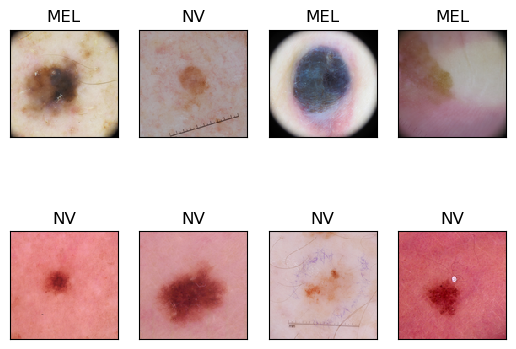

In [1]:
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

folder = ImageFolder('a5_data/train', transform=torchvision.transforms.ToTensor())
loader = DataLoader(folder, batch_size=8, shuffle=True)

Xexamples, Yexamples = next(iter(loader))

for i in range(8):
    plt.subplot(2,4,i+1)  
    img = Xexamples[i].numpy().transpose(1, 2, 0)    
    plt.imshow(img, interpolation='none')
    plt.title('NV' if Yexamples[i] else 'MEL')
    plt.xticks([])
    plt.yticks([])

# Load data

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import DatasetFolder
import os

# Convert Images to tensor
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load training and test datasets
train_dataset = datasets.ImageFolder(root='a5_data/train', transform=transform)
val_dataset = datasets.ImageFolder(root='a5_data/val', transform=transform)

# num_workers = os.cpu_count()

# CreateDataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=5)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=5)

def custom_loader(path):
    return read_image(path)

test_blind_dataset = DatasetFolder(root='a5_data/test_blind', loader=custom_loader, extensions=['png'], transform=transform)
test_blind_loader = DataLoader(test_blind_dataset, batch_size=32, shuffle=False, num_workers=5)

# Data Modelling
## Train and evaluate the model

In [3]:
# Function to plot training and validation accuracy
def plot_accuracies(training_accuracies, validation_accuracies):
    epochs = list(range(1, len(training_accuracies) + 1))
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, training_accuracies, label='Training Accuracy')
    plt.plot(epochs, validation_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xticks(epochs)
    plt.legend()
    plt.grid(True)
    plt.show()

# Train the model
def train_model(model,model_name, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    training_accuracies = []
    validation_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        training_accuracy = 100 * correct / total
        training_accuracies.append(training_accuracy)

        # Evaluate after every epoch
        val_accuracy = evaluate_model(model, val_loader, device, verbose=False)
        validation_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, '
              f'Training Accuracy: {training_accuracy:.2f} %, '
              f'Validation Accuracy: {val_accuracy:.2f} %')
    
        # Save the model checkpoint
        torch.save(model.state_dict(), f'model/{model_name}_{epoch}_{val_accuracy:.2f}.pth')
    return training_accuracies, validation_accuracies    
    
    
# Evaluate the model
def evaluate_model(model, test_loader, device, verbose=True):
    model.eval()  # Set the model to evaluation mode
    correct, total = 0, 0
    with torch.no_grad():  # No gradient tracking needed
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    if verbose:
        print(f'Accuracy of the model on the test images: {accuracy} %')
    return accuracy

## Logistic Regression

Epoch [1/10], Loss: 2.3073, Training Accuracy: 64.44 %, Validation Accuracy: 69.81 %
Epoch [2/10], Loss: 1.1697, Training Accuracy: 67.63 %, Validation Accuracy: 57.67 %
Epoch [3/10], Loss: 1.0420, Training Accuracy: 69.03 %, Validation Accuracy: 66.13 %
Epoch [4/10], Loss: 1.5668, Training Accuracy: 67.76 %, Validation Accuracy: 52.48 %
Epoch [5/10], Loss: 1.1634, Training Accuracy: 70.35 %, Validation Accuracy: 75.16 %
Epoch [6/10], Loss: 1.2279, Training Accuracy: 70.46 %, Validation Accuracy: 72.60 %
Epoch [7/10], Loss: 1.1163, Training Accuracy: 70.90 %, Validation Accuracy: 52.64 %
Epoch [8/10], Loss: 1.0642, Training Accuracy: 71.02 %, Validation Accuracy: 73.80 %
Epoch [9/10], Loss: 1.3904, Training Accuracy: 69.50 %, Validation Accuracy: 67.57 %
Epoch [10/10], Loss: 1.2625, Training Accuracy: 70.70 %, Validation Accuracy: 72.36 %


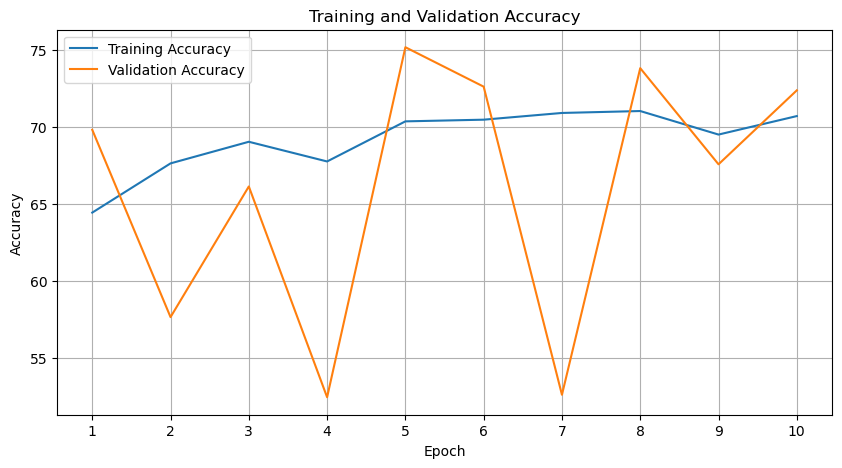

Accuracy of the model on the test images: 72.36421725239616 %


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the Logistic Regression Model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)
    
    def forward(self, x):
        # Flatten the image into a 1D vector
        x = x.view(x.size(0), -1)
        return self.linear(x)

# Initialize the model, loss function, and optimizer
input_size = 128 * 128 * 3  
num_classes = 2  # For binary classification

lr_model = LogisticRegressionModel(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(lr_model.parameters(), lr=0.001)
optimizer = optim.Adam(lr_model.parameters(), lr=0.001)

# Determine the computing device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
lr_model.to(device)  # Move model to the chosen device

# Training the model
training_accuracies, validation_accuracies = train_model(lr_model, 'lr_model',train_loader, val_loader, criterion, optimizer, num_epochs=10, device=device)

# Plot accuracies after training
plot_accuracies(training_accuracies, validation_accuracies)

# Evaluating the model
accuracy = evaluate_model(lr_model, val_loader, device=device)

## MLP Model


Epoch [1/10], Loss: 0.8553, Training Accuracy: 66.88 %, Validation Accuracy: 71.01 %
Epoch [2/10], Loss: 0.5256, Training Accuracy: 71.72 %, Validation Accuracy: 72.92 %
Epoch [3/10], Loss: 0.4941, Training Accuracy: 73.42 %, Validation Accuracy: 69.89 %
Epoch [4/10], Loss: 0.4769, Training Accuracy: 74.11 %, Validation Accuracy: 75.96 %
Epoch [5/10], Loss: 0.4812, Training Accuracy: 73.89 %, Validation Accuracy: 75.40 %
Epoch [6/10], Loss: 0.4628, Training Accuracy: 75.57 %, Validation Accuracy: 74.52 %
Epoch [7/10], Loss: 0.4676, Training Accuracy: 74.87 %, Validation Accuracy: 73.24 %
Epoch [8/10], Loss: 0.4748, Training Accuracy: 74.81 %, Validation Accuracy: 71.49 %
Epoch [9/10], Loss: 0.4589, Training Accuracy: 76.00 %, Validation Accuracy: 75.24 %
Epoch [10/10], Loss: 0.4504, Training Accuracy: 76.74 %, Validation Accuracy: 77.08 %


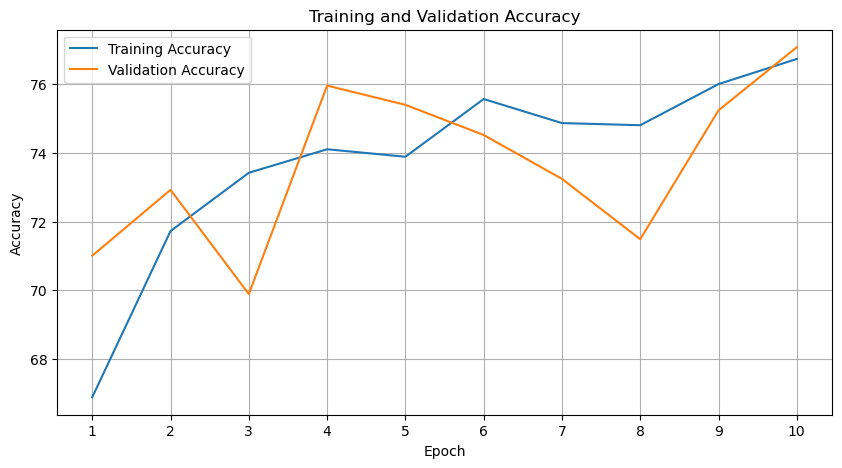

Accuracy of the model on the test images: 77.07667731629392 %


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the Multilayer Perceptron Model
class MLPModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLPModel, self).__init__()
        # Define the first hidden layer with relu activation
        self.hidden1 = nn.Linear(input_size, 512)  # 512 can be changed to another number
        # Define the second hidden layer with relu activation
        self.hidden2 = nn.Linear(512, 256)  # 256 can be changed to another number
        # Define the output layer
        self.output = nn.Linear(256, num_classes)
    
    def forward(self, x):
        # Flatten the image into a 1D vector
        x = x.view(x.size(0), -1)
        # Forward pass through the first hidden layer with relu activation
        x = torch.relu(self.hidden1(x))
        # Forward pass through the second hidden layer with relu activation
        x = torch.relu(self.hidden2(x))
        # Output layer without activation
        # CrossEntropyLoss will apply softmax activation
        out = self.output(x)
        return out

# Initialize the model, loss function, and optimizer
input_size = 128 * 128 * 3  
num_classes = 2  # For binary classification

mlp_model = MLPModel(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(mlp_model.parameters(), lr=0.001)
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# Determine the computing device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
mlp_model.to(device)  # Move model to the chosen device

# Training the model
training_accuracies, validation_accuracies = train_model(mlp_model, 'mlp_model', train_loader, val_loader, criterion, optimizer, num_epochs=10, device=device)

# Plot accuracies after training
plot_accuracies(training_accuracies, validation_accuracies)

# Evaluating the model
accuracy = evaluate_model(mlp_model, val_loader, device=device)

# Save the model checkpoint
torch.save(mlp_model.state_dict(), 'mlp_model.pth')

# Result
# Accuracy of the model on the test images: 65.65495207667732 % (num_epochs=5)
# Accuracy of the model on the test images: 66.77316293929712 % (num_epochs=10)

## CNN Model

Epoch [1/10], Loss: 0.5119, Training Accuracy: 75.26 %, Validation Accuracy: 79.23 %
Epoch [2/10], Loss: 0.4156, Training Accuracy: 78.96 %, Validation Accuracy: 79.23 %
Epoch [3/10], Loss: 0.3955, Training Accuracy: 80.39 %, Validation Accuracy: 79.07 %
Epoch [4/10], Loss: 0.3863, Training Accuracy: 81.61 %, Validation Accuracy: 80.91 %
Epoch [5/10], Loss: 0.3720, Training Accuracy: 81.57 %, Validation Accuracy: 79.47 %
Epoch [6/10], Loss: 0.3589, Training Accuracy: 82.68 %, Validation Accuracy: 80.83 %
Epoch [7/10], Loss: 0.3413, Training Accuracy: 83.71 %, Validation Accuracy: 82.83 %
Epoch [8/10], Loss: 0.3355, Training Accuracy: 83.91 %, Validation Accuracy: 78.27 %
Epoch [9/10], Loss: 0.3216, Training Accuracy: 84.77 %, Validation Accuracy: 82.03 %
Epoch [10/10], Loss: 0.3115, Training Accuracy: 85.96 %, Validation Accuracy: 81.23 %


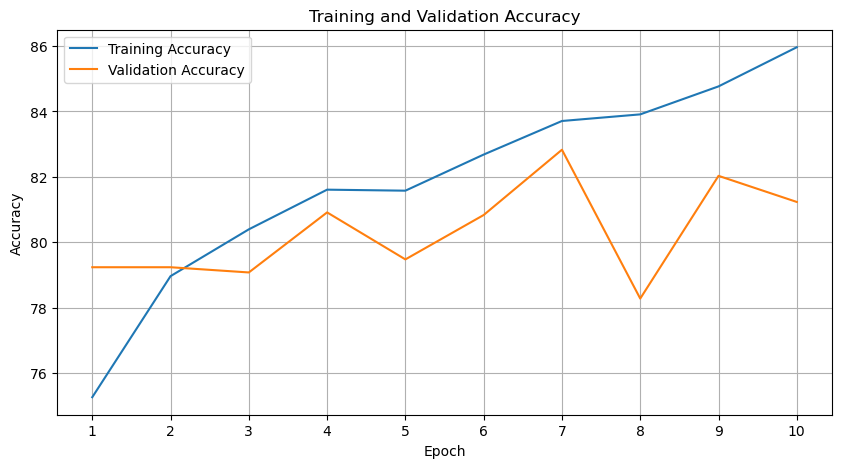

Accuracy of the model on the test images: 81.23003194888179 %


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


# Define the CNN Model
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        # Define the first convolutional layer
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        # Define the second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # Define a max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Define a fully connected layer
        self.fc = nn.Linear(64 * 32 * 32, num_classes)
    
    def forward(self, x):
        # Apply the first convolutional layer with ReLU activation
        x = F.relu(self.conv1(x))
        # Apply max pooling layer
        x = self.pool(x)
        # Apply the second convolutional layer with ReLU activation
        x = F.relu(self.conv2(x))
        # Apply max pooling layer
        x = self.pool(x)
        # Flatten the image for the fully connected layer
        x = x.view(-1, 64 * 32 * 32)
        # Apply the fully connected layer
        out = self.fc(x)
        return out

# Initialize the model, loss function, and optimizer
num_classes = 2  # For binary classification

cnn_model = CNNModel(num_classes)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(cnn_model.parameters(), lr=0.001)
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

# Determine the computing device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
cnn_model.to(device)  # Move model to the chosen device

# Training the model
training_accuracies, validation_accuracies = train_model(cnn_model, 'cnn_model', train_loader, val_loader, criterion, optimizer, num_epochs=10, device=device)

# Plot accuracies after training
plot_accuracies(training_accuracies, validation_accuracies)

# Evaluating the model
accuracy = evaluate_model(cnn_model, val_loader, device=device)

## LeNet Model

Epoch [1/20], Loss: 0.5313, Training Accuracy: 70.67 %, Validation Accuracy: 73.08 %
Epoch [2/20], Loss: 0.4370, Training Accuracy: 77.56 %, Validation Accuracy: 75.00 %
Epoch [3/20], Loss: 0.4351, Training Accuracy: 78.10 %, Validation Accuracy: 79.87 %
Epoch [4/20], Loss: 0.4073, Training Accuracy: 80.17 %, Validation Accuracy: 79.71 %
Epoch [5/20], Loss: 0.3873, Training Accuracy: 81.11 %, Validation Accuracy: 80.35 %
Epoch [6/20], Loss: 0.3901, Training Accuracy: 80.80 %, Validation Accuracy: 78.59 %
Epoch [7/20], Loss: 0.3664, Training Accuracy: 82.10 %, Validation Accuracy: 76.04 %
Epoch [8/20], Loss: 0.3640, Training Accuracy: 82.52 %, Validation Accuracy: 79.07 %
Epoch [9/20], Loss: 0.3519, Training Accuracy: 83.27 %, Validation Accuracy: 81.15 %
Epoch [10/20], Loss: 0.3538, Training Accuracy: 82.51 %, Validation Accuracy: 80.35 %
Epoch [11/20], Loss: 0.3289, Training Accuracy: 84.20 %, Validation Accuracy: 80.83 %
Epoch [12/20], Loss: 0.3095, Training Accuracy: 85.36 %, Valida

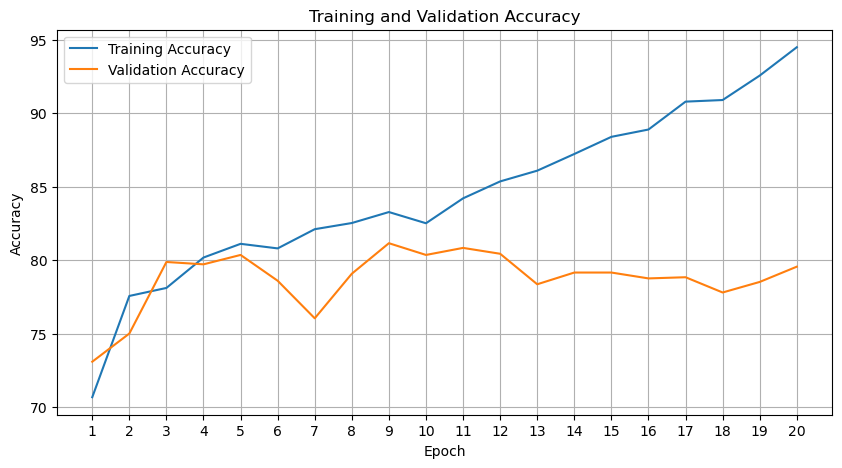

Accuracy of the model on the test images: 79.55271565495208 %


In [7]:
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 29 * 29, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 29 * 29)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
num_classes = 2  # For binary classification

lenet_model = LeNet(num_classes)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(lenet_model.parameters(), lr=0.001)
optimizer = optim.Adam(lenet_model.parameters(), lr=0.001)

# Determine the computing device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
lenet_model.to(device)  # Move model to the chosen device

# Training the model
training_accuracies, validation_accuracies = train_model(lenet_model,'lenet_model', train_loader, val_loader, criterion, optimizer, num_epochs=20, device=device)

# Plot accuracies after training
plot_accuracies(training_accuracies, validation_accuracies)

# Evaluating the model
accuracy = evaluate_model(lenet_model, val_loader, device=device)

## Normalization
### Batch normalization

Epoch [1/10], Loss: 1.8355, Training Accuracy: 74.04 %, Validation Accuracy: 75.88 %
Epoch [2/10], Loss: 1.3336, Training Accuracy: 75.86 %, Validation Accuracy: 80.19 %
Epoch [3/10], Loss: 1.1638, Training Accuracy: 77.48 %, Validation Accuracy: 71.96 %
Epoch [4/10], Loss: 0.7048, Training Accuracy: 80.27 %, Validation Accuracy: 75.96 %
Epoch [5/10], Loss: 0.8979, Training Accuracy: 79.47 %, Validation Accuracy: 73.40 %
Epoch [6/10], Loss: 0.6590, Training Accuracy: 80.69 %, Validation Accuracy: 79.63 %
Epoch [7/10], Loss: 0.4868, Training Accuracy: 81.70 %, Validation Accuracy: 79.55 %
Epoch [8/10], Loss: 0.4762, Training Accuracy: 82.59 %, Validation Accuracy: 79.71 %
Epoch [9/10], Loss: 0.4232, Training Accuracy: 83.47 %, Validation Accuracy: 79.79 %
Epoch [10/10], Loss: 0.3922, Training Accuracy: 84.84 %, Validation Accuracy: 79.39 %


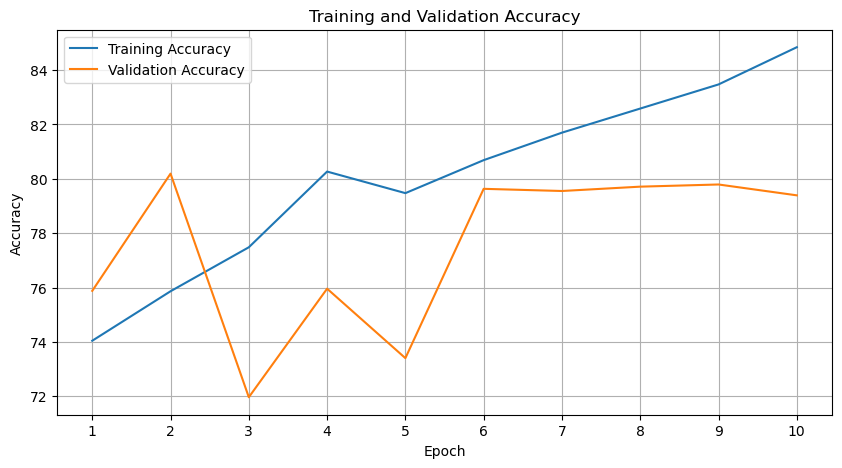

Accuracy of the model on the test images: 79.3929712460064 %


In [10]:
# Define the CNN Model with Batch Normalization
class CNNModel_BN(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel_BN, self).__init__()
        # Define the first convolutional layer
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        # Batch Normalization layer after the first convolutional layer
        self.bn1 = nn.BatchNorm2d(32)
        # Define the second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # Batch Normalization layer after the second convolutional layer
        self.bn2 = nn.BatchNorm2d(64)
        # Define a max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Adjust the fully connected layer to match the flattened dimension
        self.fc = nn.Linear(64 * 32 * 32, num_classes)
    
    def forward(self, x):
        # Apply the first convolutional layer with ReLU activation and Batch Normalization
        x = F.relu(self.bn1(self.conv1(x)))
        # Apply max pooling layer
        x = self.pool(x)
        # Apply the second convolutional layer with ReLU activation and Batch Normalization
        x = F.relu(self.bn2(self.conv2(x)))
        # Apply max pooling layer
        x = self.pool(x)
        # Flatten the image for the fully connected layer
        x = x.view(-1, 64 * 32 * 32)
        # Apply the fully connected layer
        out = self.fc(x)
        return out

# Initialize the model, loss function, and optimizer
num_classes = 2  # For binary classification

cnnBN_model = CNNModel_BN(num_classes)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(cnn_model.parameters(), lr=0.001)
optimizer = optim.Adam(cnnBN_model.parameters(), lr=0.001)

# Determine the computing device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
cnnBN_model.to(device)  # Move model to the chosen device

# Training the model
training_accuracies, validation_accuracies = train_model(cnnBN_model, 'cnnBN_model', train_loader, val_loader, criterion, optimizer, num_epochs=10, device=device)

# Plot accuracies after training
plot_accuracies(training_accuracies, validation_accuracies)

# Evaluating the model
accuracy = evaluate_model(cnnBN_model, val_loader, device=device)


Epoch [1/10], Loss: 0.4301, Training Accuracy: 78.66 %, Validation Accuracy: 69.89 %
Epoch [2/10], Loss: 0.3878, Training Accuracy: 81.00 %, Validation Accuracy: 78.04 %
Epoch [3/10], Loss: 0.3515, Training Accuracy: 83.58 %, Validation Accuracy: 78.43 %
Epoch [4/10], Loss: 0.3184, Training Accuracy: 85.39 %, Validation Accuracy: 78.99 %
Epoch [5/10], Loss: 0.2798, Training Accuracy: 87.54 %, Validation Accuracy: 79.39 %
Epoch [6/10], Loss: 0.2383, Training Accuracy: 89.51 %, Validation Accuracy: 82.27 %
Epoch [7/10], Loss: 0.1866, Training Accuracy: 91.88 %, Validation Accuracy: 61.58 %
Epoch [8/10], Loss: 0.1698, Training Accuracy: 93.12 %, Validation Accuracy: 80.91 %
Epoch [9/10], Loss: 0.1222, Training Accuracy: 95.05 %, Validation Accuracy: 78.75 %
Epoch [10/10], Loss: 0.0879, Training Accuracy: 96.75 %, Validation Accuracy: 81.47 %


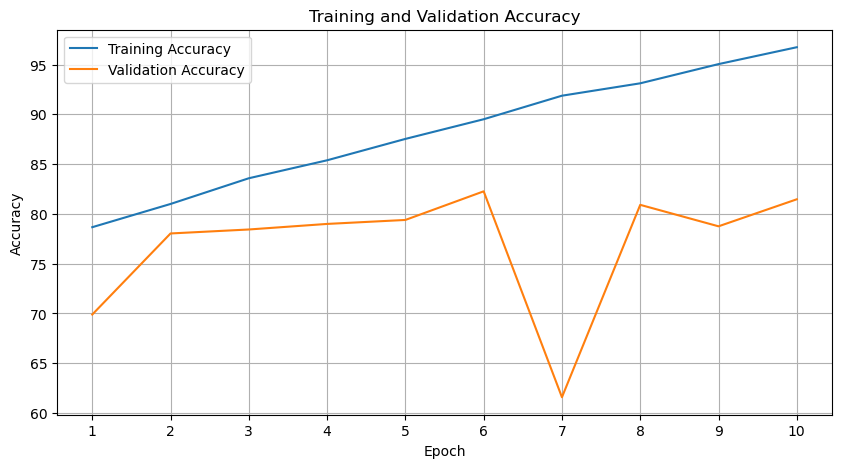

Accuracy of the model on the test images: 81.46964856230032 %


In [14]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class LeNetBN(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNetBN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 29 * 29, 120)
        self.bn3 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.bn4 = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 16 * 29 * 29)
        x = F.relu(self.bn3(self.fc1(x)))
        x = F.relu(self.bn4(self.fc2(x)))
        x = self.fc3(x)
        return x


# Initialize the model, loss function, and optimizer
num_classes = 2  # For binary classification

lenetBN_model = LeNetBN(num_classes)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(lenet_model.parameters(), lr=0.001)
optimizer = optim.Adam(lenetBN_model.parameters(), lr=0.001)

# Determine the computing device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
lenetBN_model.to(device)  # Move model to the chosen device

# Training the model
training_accuracies, validation_accuracies = train_model(lenetBN_model,'lenetBN_model', train_loader, val_loader, criterion, optimizer, num_epochs=10, device=device)

# Plot accuracies after training
plot_accuracies(training_accuracies, validation_accuracies)

# Evaluating the model
accuracy = evaluate_model(lenetBN_model, val_loader, device=device)



### Layer normalization

Epoch [1/10], Loss: 1.2801, Training Accuracy: 70.07 %, Validation Accuracy: 76.20 %
Epoch [2/10], Loss: 0.6232, Training Accuracy: 74.32 %, Validation Accuracy: 77.08 %
Epoch [3/10], Loss: 0.6348, Training Accuracy: 76.16 %, Validation Accuracy: 72.28 %
Epoch [4/10], Loss: 0.5144, Training Accuracy: 78.59 %, Validation Accuracy: 80.19 %
Epoch [5/10], Loss: 0.5086, Training Accuracy: 79.38 %, Validation Accuracy: 81.15 %
Epoch [6/10], Loss: 0.4502, Training Accuracy: 81.09 %, Validation Accuracy: 76.36 %
Epoch [7/10], Loss: 0.4036, Training Accuracy: 81.92 %, Validation Accuracy: 80.75 %
Epoch [8/10], Loss: 0.3637, Training Accuracy: 83.32 %, Validation Accuracy: 81.87 %
Epoch [9/10], Loss: 0.3281, Training Accuracy: 85.39 %, Validation Accuracy: 82.11 %
Epoch [10/10], Loss: 0.3385, Training Accuracy: 85.06 %, Validation Accuracy: 81.15 %


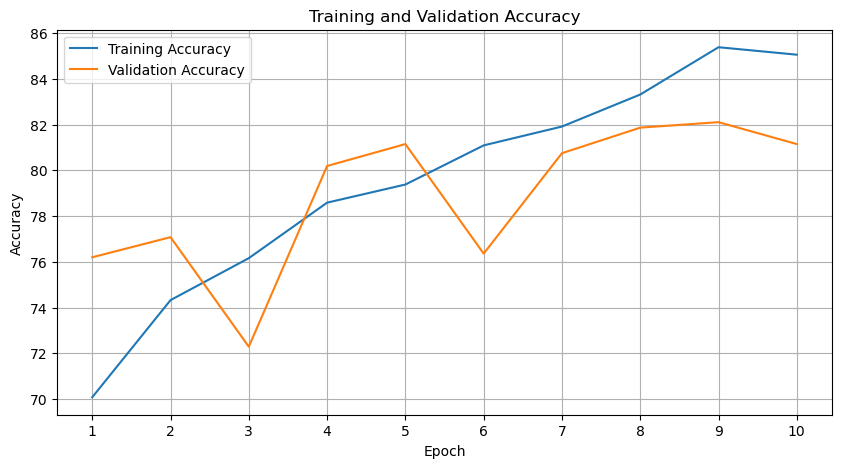

Accuracy of the model on the test images: 81.15015974440895 %


In [12]:
# Define the CNN Model with Batch Normalization
class CNNModel_LN(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel_LN, self).__init__()
        # Define the first convolutional layer
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.ln1 = nn.LayerNorm([32, 128, 128])

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.ln2 = nn.LayerNorm([64, 64, 64])

        # Define a max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Adjust the fully connected layer to match the flattened dimension
        self.fc = nn.Linear(64 * 32 * 32, num_classes)
    
    def forward(self, x):
        # Apply the first convolutional layer with ReLU activation and Batch Normalization
        x = F.relu(self.ln1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.ln2(self.conv2(x)))
        x = self.pool(x)

        # Flatten the image for the fully connected layer
        x = x.view(-1, 64 * 32 * 32)
        # Apply the fully connected layer
        out = self.fc(x)
        return out

# Initialize the model, loss function, and optimizer
num_classes = 2  # For binary classification

cnnLN_model = CNNModel_LN(num_classes)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(cnn_model.parameters(), lr=0.001)
optimizer = optim.Adam(cnnLN_model.parameters(), lr=0.001)

# Determine the computing device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
cnnLN_model.to(device)  # Move model to the chosen device

# Training the model
training_accuracies, validation_accuracies = train_model(cnnLN_model, 'cnnLN_model', train_loader, val_loader, criterion, optimizer, num_epochs=10, device=device)

# Plot accuracies after training
plot_accuracies(training_accuracies, validation_accuracies)

# Evaluating the model
accuracy = evaluate_model(cnnLN_model, val_loader, device=device)


In [13]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class LeNetLN(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNetLN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.ln1 = nn.LayerNorm([6, 62, 62])

        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.ln2 = nn.LayerNorm([16, 29, 29])

        self.fc1 = nn.Linear(16 * 29 * 29, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.relu(self.ln1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.ln2(self.conv2(x)))
        x = self.pool(x)
        x = x.view(-1, 16 * 29 * 29)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



# Initialize the model, loss function, and optimizer
num_classes = 2  # For binary classification

LeNetLN_model = LeNetLN(num_classes)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(lenet_model.parameters(), lr=0.001)
optimizer = optim.Adam(LeNetLN_model.parameters(), lr=0.001)

# Determine the computing device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
LeNetLN_model.to(device)  # Move model to the chosen device

# Training the model
training_accuracies, validation_accuracies = train_model(LeNetLN_model,'LeNetLN_model', train_loader, val_loader, criterion, optimizer, num_epochs=10, device=device)

# Plot accuracies after training
plot_accuracies(training_accuracies, validation_accuracies)

# Evaluating the model
accuracy = evaluate_model(LeNetLN_model, val_loader, device=device)


RuntimeError: Given normalized_shape=[6, 62, 62], expected input with shape [*, 6, 62, 62], but got input of size[32, 6, 124, 124]

### Group normalization

Epoch [1/10], Loss: 1.4126, Training Accuracy: 68.86 %, Validation Accuracy: 79.31 %
Epoch [2/10], Loss: 0.6561, Training Accuracy: 75.38 %, Validation Accuracy: 77.40 %
Epoch [3/10], Loss: 0.5288, Training Accuracy: 76.91 %, Validation Accuracy: 71.49 %
Epoch [4/10], Loss: 0.5106, Training Accuracy: 79.05 %, Validation Accuracy: 77.64 %
Epoch [5/10], Loss: 0.4455, Training Accuracy: 79.79 %, Validation Accuracy: 82.51 %
Epoch [6/10], Loss: 0.4051, Training Accuracy: 80.83 %, Validation Accuracy: 81.23 %
Epoch [7/10], Loss: 0.3897, Training Accuracy: 82.37 %, Validation Accuracy: 72.04 %
Epoch [8/10], Loss: 0.3678, Training Accuracy: 82.65 %, Validation Accuracy: 79.31 %
Epoch [9/10], Loss: 0.3442, Training Accuracy: 84.24 %, Validation Accuracy: 73.88 %
Epoch [10/10], Loss: 0.3308, Training Accuracy: 84.61 %, Validation Accuracy: 81.07 %


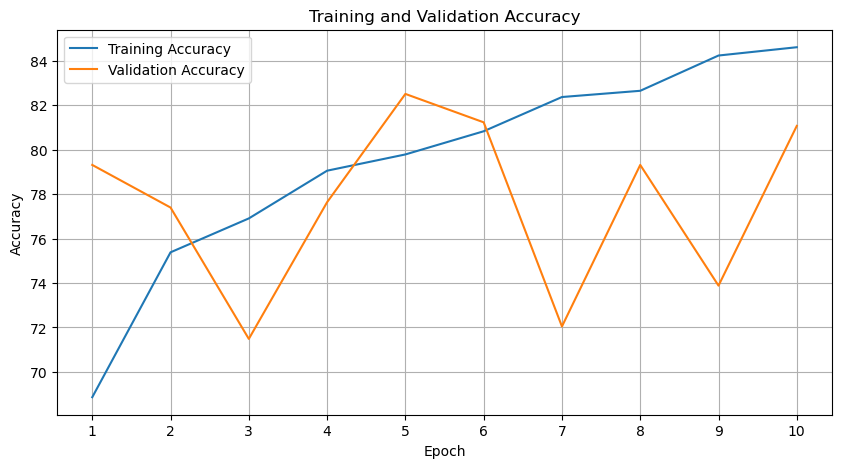

Accuracy of the model on the test images: 81.0702875399361 %


In [11]:
# Define the CNN Model with Batch Normalization
class CNNModel_GN(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel_GN, self).__init__()
        # Define the first convolutional layer
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.gn1 = nn.GroupNorm(4, 32) 

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.gn2 = nn.GroupNorm(4, 64)

        # Define a max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Adjust the fully connected layer to match the flattened dimension
        self.fc = nn.Linear(64 * 32 * 32, num_classes)
    
    def forward(self, x):
        # Apply the first convolutional layer with ReLU activation and Group Normalization
        x = F.relu(self.gn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.gn2(self.conv2(x)))
        x = self.pool(x)


        # Flatten the image for the fully connected layer
        x = x.view(-1, 64 * 32 * 32)
        # Apply the fully connected layer
        out = self.fc(x)
        return out

# Initialize the model, loss function, and optimizer
num_classes = 2  # For binary classification

cnnGN_model = CNNModel_GN(num_classes)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(cnn_model.parameters(), lr=0.001)
optimizer = optim.Adam(cnnGN_model.parameters(), lr=0.001)

# Determine the computing device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
cnnGN_model.to(device)  # Move model to the chosen device

# Training the model
training_accuracies, validation_accuracies = train_model(cnnGN_model, 'cnnGN_model', train_loader, val_loader, criterion, optimizer, num_epochs=10, device=device)

# Plot accuracies after training
plot_accuracies(training_accuracies, validation_accuracies)

# Evaluating the model
accuracy = evaluate_model(cnnGN_model, val_loader, device=device)


Epoch [1/10], Loss: 0.5081, Training Accuracy: 72.70 %, Validation Accuracy: 76.52 %
Epoch [2/10], Loss: 0.4407, Training Accuracy: 77.72 %, Validation Accuracy: 75.88 %
Epoch [3/10], Loss: 0.4113, Training Accuracy: 79.82 %, Validation Accuracy: 80.03 %
Epoch [4/10], Loss: 0.3849, Training Accuracy: 81.08 %, Validation Accuracy: 79.23 %
Epoch [5/10], Loss: 0.3774, Training Accuracy: 81.25 %, Validation Accuracy: 79.55 %
Epoch [6/10], Loss: 0.3556, Training Accuracy: 82.42 %, Validation Accuracy: 77.56 %
Epoch [7/10], Loss: 0.3475, Training Accuracy: 82.45 %, Validation Accuracy: 78.99 %
Epoch [8/10], Loss: 0.3411, Training Accuracy: 83.64 %, Validation Accuracy: 79.95 %
Epoch [9/10], Loss: 0.3163, Training Accuracy: 85.22 %, Validation Accuracy: 81.07 %
Epoch [10/10], Loss: 0.2960, Training Accuracy: 85.67 %, Validation Accuracy: 80.99 %


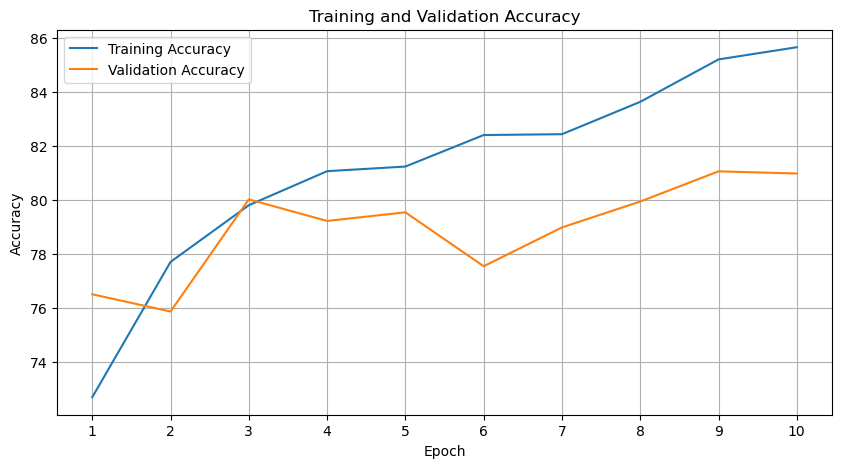

Accuracy of the model on the test images: 80.99041533546325 %


In [15]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torch.nn as nn
import torch.nn.functional as F

class LeNetGN(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNetGN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.gn1 = nn.GroupNorm(3, 6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.gn2 = nn.GroupNorm(4, 16)
        self.fc1 = nn.Linear(16 * 29 * 29, 120)
        self.gn3 = nn.GroupNorm(1, 120)
        self.fc2 = nn.Linear(120, 84)
        self.gn4 = nn.GroupNorm(1, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.gn1(self.conv1(x))))
        x = self.pool(F.relu(self.gn2(self.conv2(x))))
        x = x.view(-1, 16 * 29 * 29)
        x = F.relu(self.gn3(self.fc1(x)))
        x = F.relu(self.gn4(self.fc2(x)))
        x = self.fc3(x)
        return x


# Initialize the model, loss function, and optimizer
num_classes = 2  # For binary classification

LeNetGN_model = LeNetGN(num_classes)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(lenet_model.parameters(), lr=0.001)
optimizer = optim.Adam(LeNetGN_model.parameters(), lr=0.001)

# Determine the computing device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
LeNetGN_model.to(device)  # Move model to the chosen device

# Training the model
training_accuracies, validation_accuracies = train_model(LeNetGN_model,'LeNetGN_model', train_loader, val_loader, criterion, optimizer, num_epochs=10, device=device)

# Plot accuracies after training
plot_accuracies(training_accuracies, validation_accuracies)

# Evaluating the model
accuracy = evaluate_model(LeNetGN_model, val_loader, device=device)



## Residual connections


Epoch [1/10], Loss: 4.3936, Training Accuracy: 74.54 %, Validation Accuracy: 74.12 %
Epoch [2/10], Loss: 0.6070, Training Accuracy: 81.96 %, Validation Accuracy: 80.11 %
Epoch [3/10], Loss: 0.2899, Training Accuracy: 88.24 %, Validation Accuracy: 81.79 %
Epoch [4/10], Loss: 0.1923, Training Accuracy: 92.45 %, Validation Accuracy: 81.23 %
Epoch [5/10], Loss: 0.1511, Training Accuracy: 94.24 %, Validation Accuracy: 78.27 %
Epoch [6/10], Loss: 0.1444, Training Accuracy: 94.88 %, Validation Accuracy: 81.47 %
Epoch [7/10], Loss: 0.0941, Training Accuracy: 97.04 %, Validation Accuracy: 81.39 %
Epoch [8/10], Loss: 0.0589, Training Accuracy: 98.26 %, Validation Accuracy: 80.83 %
Epoch [9/10], Loss: 0.0386, Training Accuracy: 98.79 %, Validation Accuracy: 80.67 %
Epoch [10/10], Loss: 0.0304, Training Accuracy: 99.18 %, Validation Accuracy: 81.23 %


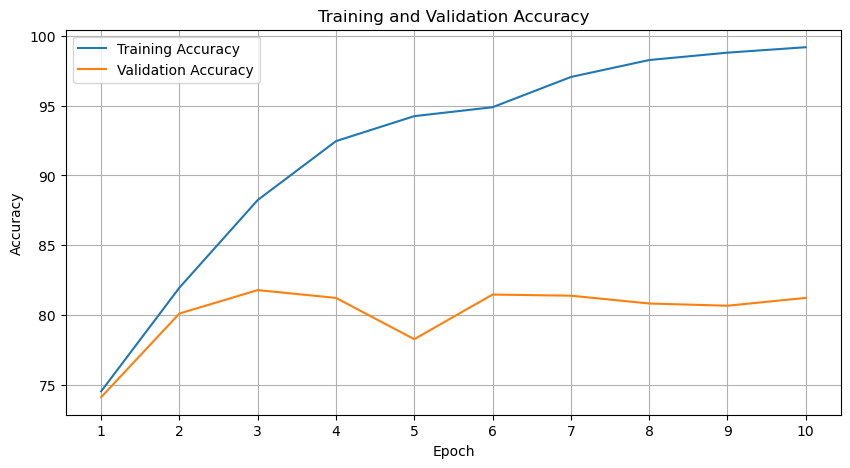

Accuracy of the model on the test images: 81.23003194888179 %
Validation Accuracy: 81.23003194888179%


In [14]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt


transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(root='a5_data/train', transform=transform)
val_dataset = datasets.ImageFolder(root='a5_data/val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=5)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=5)


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(residual)
        out = F.relu(out)
        return out


class CNNModelWithResiduals(nn.Module):
    def __init__(self, num_classes):
        super(CNNModelWithResiduals, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = ResidualBlock(32, 64, stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc = nn.Linear(64 * 64 * 64, num_classes)  # Adjusted for 128x128 images

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.layer1(x)
        x = x.view(-1, 64 * 64 * 64)  # Adjusted for the output size after the residual block
        out = self.fc(x)
        return out

num_classes = 2
cnn_res_model = CNNModelWithResiduals(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_res_model.parameters(), lr=0.001)

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
cnn_res_model.to(device)

num_epochs = 10
training_accuracies, validation_accuracies = train_model(cnn_res_model,'cnn_res_model', train_loader, val_loader, criterion, optimizer, num_epochs, device)

plot_accuracies(training_accuracies, validation_accuracies)
accuracy = evaluate_model(cnn_res_model, val_loader, device)
print(f'Validation Accuracy: {accuracy}%')


Epoch [1/10], Loss: 0.4726, Training Accuracy: 74.96 %, Validation Accuracy: 75.24 %
Epoch [2/10], Loss: 0.4158, Training Accuracy: 79.08 %, Validation Accuracy: 77.32 %
Epoch [3/10], Loss: 0.3839, Training Accuracy: 81.43 %, Validation Accuracy: 77.56 %
Epoch [4/10], Loss: 0.3631, Training Accuracy: 82.60 %, Validation Accuracy: 80.19 %
Epoch [5/10], Loss: 0.3347, Training Accuracy: 84.14 %, Validation Accuracy: 79.95 %
Epoch [6/10], Loss: 0.2833, Training Accuracy: 87.30 %, Validation Accuracy: 76.60 %
Epoch [7/10], Loss: 0.2217, Training Accuracy: 90.41 %, Validation Accuracy: 78.91 %
Epoch [8/10], Loss: 0.1602, Training Accuracy: 93.40 %, Validation Accuracy: 79.95 %
Epoch [9/10], Loss: 0.1088, Training Accuracy: 95.91 %, Validation Accuracy: 80.27 %
Epoch [10/10], Loss: 0.0748, Training Accuracy: 97.29 %, Validation Accuracy: 78.43 %


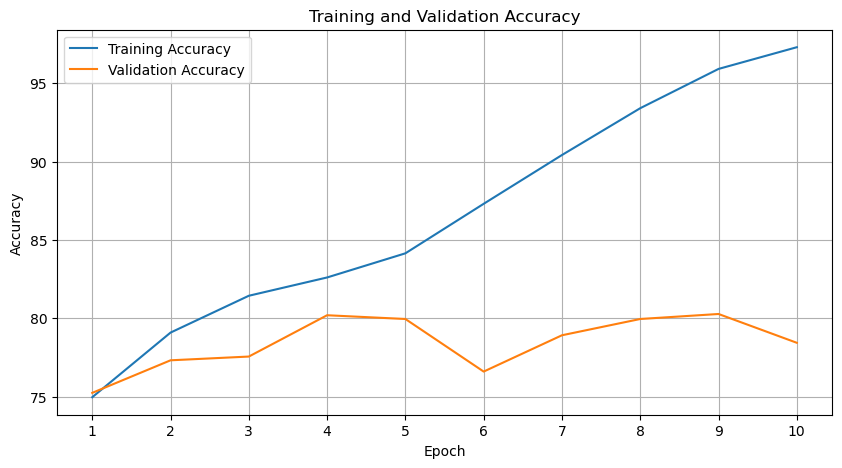

Accuracy of the model on the test images: 78.43450479233226 %
Validation Accuracy: 78.43450479233226%


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(residual)
        out = F.relu(out)
        return out


class LeNetWithResiduals(nn.Module):
    def __init__(self):
        super(LeNetWithResiduals, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.res_block = ResidualBlock(6, 6)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 29 * 29, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.res_block(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 29 * 29)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


num_classes = 2
lenet_res_model = LeNetWithResiduals()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet_res_model.parameters(), lr=0.001)

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
lenet_res_model.to(device)

num_epochs = 10
training_accuracies, validation_accuracies = train_model(lenet_res_model,'lenet_res_model', train_loader, val_loader, criterion, optimizer, num_epochs, device)

plot_accuracies(training_accuracies, validation_accuracies)
accuracy = evaluate_model(lenet_res_model, val_loader, device)
print(f'Validation Accuracy: {accuracy}%')


## Data Augmentation


Epoch [1/30], Loss: 0.6383, Training Accuracy: 67.57 %, Validation Accuracy: 72.76 %
Epoch [2/30], Loss: 0.5298, Training Accuracy: 70.00 %, Validation Accuracy: 74.60 %
Epoch [3/30], Loss: 0.5187, Training Accuracy: 69.36 %, Validation Accuracy: 75.56 %
Epoch [4/30], Loss: 0.5033, Training Accuracy: 71.16 %, Validation Accuracy: 75.08 %
Epoch [5/30], Loss: 0.4881, Training Accuracy: 74.00 %, Validation Accuracy: 77.80 %
Epoch [6/30], Loss: 0.4750, Training Accuracy: 75.54 %, Validation Accuracy: 76.76 %
Epoch [7/30], Loss: 0.4588, Training Accuracy: 76.17 %, Validation Accuracy: 80.99 %
Epoch [8/30], Loss: 0.4697, Training Accuracy: 76.22 %, Validation Accuracy: 80.03 %
Epoch [9/30], Loss: 0.4538, Training Accuracy: 76.83 %, Validation Accuracy: 82.27 %
Epoch [10/30], Loss: 0.4539, Training Accuracy: 77.12 %, Validation Accuracy: 81.39 %
Epoch [11/30], Loss: 0.4428, Training Accuracy: 78.01 %, Validation Accuracy: 82.51 %
Epoch [12/30], Loss: 0.4437, Training Accuracy: 77.78 %, Valida

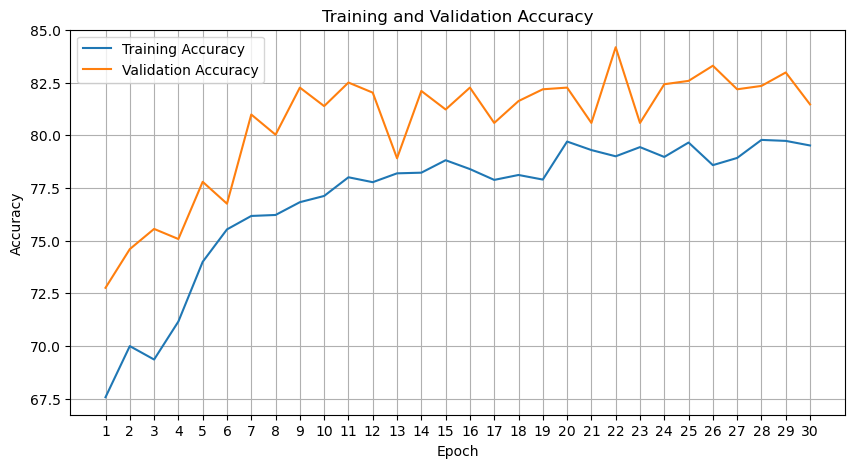

Accuracy of the model on the test images: 81.46964856230032 %


In [19]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(root='a5_data/train', transform=train_transforms)
val_dataset = datasets.ImageFolder(root='a5_data/val', transform=val_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# Initialize the model, loss function, and optimizer
num_classes = 2  # For binary classification

cnn_da_model = CNNModel(num_classes)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(cnn_model.parameters(), lr=0.001)
optimizer = optim.Adam(cnn_da_model.parameters(), lr=0.001)

# Determine the computing device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
cnn_da_model.to(device)  # Move model to the chosen device

# Training the model
training_accuracies, validation_accuracies = train_model(cnn_da_model, 'cnn_da_model', train_loader, val_loader, criterion, optimizer, num_epochs=30, device=device)

# Plot accuracies after training
plot_accuracies(training_accuracies, validation_accuracies)

# Evaluating the model
accuracy = evaluate_model(cnn_da_model, val_loader, device=device)


Epoch [1/30], Loss: 0.6431, Training Accuracy: 66.31 %, Validation Accuracy: 70.61 %
Epoch [2/30], Loss: 0.5459, Training Accuracy: 69.58 %, Validation Accuracy: 75.32 %
Epoch [3/30], Loss: 0.5208, Training Accuracy: 71.46 %, Validation Accuracy: 76.36 %
Epoch [4/30], Loss: 0.5027, Training Accuracy: 73.62 %, Validation Accuracy: 77.80 %
Epoch [5/30], Loss: 0.4895, Training Accuracy: 74.15 %, Validation Accuracy: 78.99 %
Epoch [6/30], Loss: 0.4750, Training Accuracy: 75.55 %, Validation Accuracy: 80.51 %
Epoch [7/30], Loss: 0.4647, Training Accuracy: 75.96 %, Validation Accuracy: 79.39 %
Epoch [8/30], Loss: 0.4641, Training Accuracy: 76.38 %, Validation Accuracy: 80.67 %
Epoch [9/30], Loss: 0.4448, Training Accuracy: 77.39 %, Validation Accuracy: 81.55 %
Epoch [10/30], Loss: 0.4563, Training Accuracy: 76.81 %, Validation Accuracy: 78.75 %
Epoch [11/30], Loss: 0.4610, Training Accuracy: 76.36 %, Validation Accuracy: 81.23 %
Epoch [12/30], Loss: 0.4512, Training Accuracy: 77.11 %, Valida

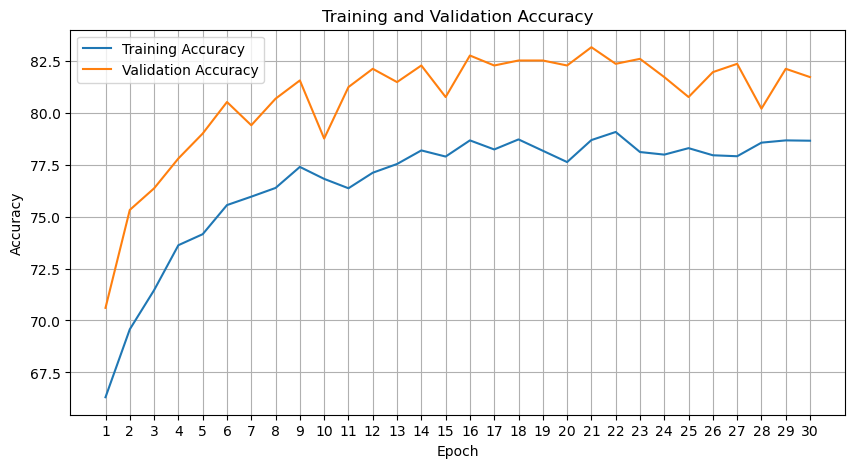

Accuracy of the model on the test images: 81.70926517571885 %


In [20]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(root='a5_data/train', transform=train_transforms)
val_dataset = datasets.ImageFolder(root='a5_data/val', transform=val_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# Initialize the model, loss function, and optimizer
num_classes = 2  # For binary classification

cnn_da_model = CNNModel(num_classes)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(cnn_model.parameters(), lr=0.001)
optimizer = optim.Adam(cnn_da_model.parameters(), lr=0.001)

# Determine the computing device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
cnn_da_model.to(device)  # Move model to the chosen device

# Training the model
training_accuracies, validation_accuracies = train_model(cnn_da_model, 'cnn_da_1_model', train_loader, val_loader, criterion, optimizer, num_epochs=30, device=device)

# Plot accuracies after training
plot_accuracies(training_accuracies, validation_accuracies)

# Evaluating the model
accuracy = evaluate_model(cnn_da_model, val_loader, device=device)